# 暂退法（dropout）
    在前向传播得过程中，计算每一内部层的同时注入噪音
在整个训练过程的每一次迭代中，标准暂退法包括在计算下一层之前将当前层中的一些节点置零。

关键的挑战是如何注入这种噪音？一种想法是以一种**无偏差的方式**注入噪音。这样在固定住其他层时，每一层的期望值等于没有噪音时的值。

<img src="picture\1.png"  width="400px" />

在一定概率下，变为0，一些数据变大，保证整体的数据期望不变。

## 实践中的暂退法
当我们将暂退法应用到隐藏层的，以p的概率将隐藏层的神经元置为零，结果可以看作是一个值包含原石神经元子集的网络。
如下图，删除了h2和h5，因为输出的计算不再依赖于h2和h5，并且它们各自的梯度在执行反向传播时也会消失。
<img src="picture\2.jpg"  width="700px" />

然而也有一些例外：一些研究人员在测试时使用暂退法，用于估计神经网络预测的“不确定性”： 如果通过许多不同的暂退法遮盖后得到的预测结果都是一致的，那么我们可以说网络发挥更稳定。


## 总结
* 丢弃法将一些输出项随机置0来空值模型的复杂度
* 常作用在多层感知机的隐藏层输出上
* 丢弃概率是控制模型复杂度的超参数

## 实践环节
我们从均匀分布的 U[0,1] 中抽样，样本数与这层神经网络的维度一致，然后我们保留那些对应样本大于p的节点，把剩下的丢弃。

在下面的代码中，我们实现 dropout_layer 函数， 该函数以dropout的概率丢弃张量输入X中的元素， 如上所述重新缩放剩余部分：将剩余部分除以1.0-dropout。

In [1]:
import torch
import torchvision
from torch import nn
from torchvision import transforms
from torch.utils  import data 
import matplotlib.pyplot as plt

In [2]:
def dropout_layer(x,dropout):
    assert 0<= dropout <=1   #True继续执行下面的程序，反之，异常结束程序
    #全部神经元丢弃
    if dropout==1:  
        return torch.zeros_like(x)  #全部为0
    #所有神经元保留
    if dropout==0:
        return x
    '''
    torch.rand(x.shape):0~1之间的均匀分布
    torch.rand(x.shape)>dropout:返回一个True和False的数据
    (torch.rand(x.shape)>dropout).float():将True和False转为1和0
    '''
    mask=(torch.rand(x.shape)>dropout).float() 
    return mask*x/(1-dropout)  #返回dropout后的数据

x=torch.arange(16,dtype=torch.float32).reshape((2,8))
print(x)
print(dropout_layer(x,0.1))
print(dropout_layer(x,0.6))


tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
tensor([[ 0.0000,  1.1111,  2.2222,  3.3333,  0.0000,  5.5556,  6.6667,  7.7778],
        [ 8.8889, 10.0000, 11.1111, 12.2222, 13.3333, 14.4444, 15.5556, 16.6667]])
tensor([[ 0.0000,  2.5000,  5.0000,  7.5000,  0.0000, 12.5000, 15.0000,  0.0000],
        [20.0000,  0.0000,  0.0000,  0.0000, 30.0000, 32.5000, 35.0000,  0.0000]])


### 定义参数

In [3]:
batch_size=64
resize=40  #图片像素
num_epochs=20
inputs_shape,outputs_shape,hiddens1,hiddens2=28*28,10,256,120
dropout1=0.2
dropout2=0.4
lr=0.1

### 数据集

In [4]:
def load_data(batch_size,resize=None):
    # 通过ToTensor实例将图像数据从PIL类型变换成32位浮点数格式，
    # 并除以255使得所有像素的数值均在0到1之间
    trans =[transforms.ToTensor()]
    #修改图片大小
    if resize:
        trans.insert(0,transforms.Resize(resize)) 
    trans=transforms.Compose(trans)
    #下载训练数据
    mnist_train = torchvision.datasets.FashionMNIST(
        root="datasets",  #保存的目录
        train=True,       #下载的是训练数据集
        transform=trans,   #得到的是pytorch的tensor，而不是图片
        download=True)  #从网上下载
    #下载测试数据
    mnist_test = torchvision.datasets.FashionMNIST(
        root="datasets", train=False, transform=trans, download=True)
    #装载数据集
    train_iter=data.DataLoader(dataset=mnist_train,
                                batch_size=batch_size,
                                shuffle=True)   #数据是否打乱
    test_iter=data.DataLoader(dataset=mnist_test,
                                        batch_size=64,
                                        shuffle=True)
    #返回训练集和测试集
    return train_iter,test_iter

train_iter,test_iter=load_data(batch_size=batch_size,resize=None)

### 定义模型
    下面的模型将第一个和第二个隐藏层的暂退概率分别设置为0.2和0.5， 并且暂退法只在训练期间有效。 



In [5]:
net = nn.Sequential(
        nn.Flatten(),
        nn.Linear(inputs_shape,hiddens1),
        nn.ReLU(),
        # 在第一个全连接层之后添加一个dropout层
        nn.Dropout(dropout1),
        nn.Linear(hiddens1,hiddens2),
        nn.ReLU(),
        # 在第二个全连接层之后添加一个dropout层
        nn.Dropout(dropout2),
        nn.Linear(hiddens2,outputs_shape))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)
net.apply(init_weights)  #初始化w

loss=torch.nn.CrossEntropyLoss()  #交叉熵
optimizer=torch.optim.SGD(net.parameters(),lr=lr)

In [6]:
'''定义预测准确率函数'''
def acc(y_hat,y):
    '''
    :param y_hat: 接收二维张量，例如 torch.tensor([[1], [0]...])
    :param y: 接收二维张量，例如 torch.tensor([[0.1, 0.2, 0.7], [0.8, 0.1, 0.1]...]) 三分类问题
    :return:
    '''
    y_hat=y_hat.argmax(axis=1)
    cmp=y_hat.type(y.dtype)==y  #数据类型是否相同
    return float(cmp.type(y.dtype).sum())
    
class Accumulator():
    ''' 对评估的正确数量和总数进行累加 '''
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, item):
        return self.data[item]

'''自定义每个批次训练函数'''
def train_epoch_cha3(net,train_iter,loss,optimizer):
    #判断是不是pytorch得model，如果是，就打开训练模式，pytorch得训练模式默认开启梯度更新
    if isinstance(net,torch.nn.Module):
        net.train()
    #创建样本累加器【累加每批次的损失值、样本预测正确的个数、样本总数】
    metric = Accumulator(3)  
    for x,y in train_iter:
        #前向传播获取预测结果
        y_hat=net(x)
        #计算损失
        l=loss(y_hat,y) 
        #判断是pytorch自带得方法还是我们手写得方法（根据不同得方法有不同得处理方式）
        if isinstance(optimizer,torch.optim.Optimizer):
            #梯度清零
            optimizer.zero_grad()
            #损失之求和，反向传播（pytorch自动进行了损失值计算）
            l.backward()
            #更新梯度
            optimizer.step()
            #累加个参数
            metric.add(
                float(l)*len(y),  #损失值总数
                acc(y_hat,y),     #计算预测正确得总数
                y.size().numel()  #样本总数
            )
    #返回平均损失值，预测正确得概率
    return metric[0]/metric[2],metric[1]/metric[2]    

'''模型测试'''
def test_cha3(net,test_iter):
    if isinstance(net,torch.nn.Module):
        net.eval()  #将模型设置为评估模式
    metric=Accumulator(2)
    for x,y in test_iter:
        metric.add(
            acc(net(x),y),  #计算准确个数
            y.numel()  #测试样本总数
        )
    #返回模型得准确率
    print(f"test_acc={metric[0]/metric[1]:.2f}%")
    return metric[0]/metric[1]

'''正式训练'''
def train_cha3(num_epochs,net,train_iter,test_iter,loss,optimizer):
    loss_list=[]
    train_acc=[]
    test_acc=[]
    for epoch in range(num_epochs):
        #计算训练数据的平均损失值和正确率
        train_metrics=train_epoch_cha3(net,train_iter,loss,optimizer)
        loss_list.append(train_metrics[0])  #保存loss
        train_acc.append(train_metrics[1])   #保存准确率
        #计算验证集的准确率
        test_metrics=test_cha3(net,test_iter)
        test_acc.append(test_metrics)
        print(f"epoch{epoch+1}:loss={train_metrics[0]},train_acc={train_metrics[1]*100:.2f}%,test_acc={test_metrics:.2f}%")
                
    return loss_list,train_acc,test_acc



In [7]:
loss_list,train_acc,test_acc=train_cha3(num_epochs,net,train_iter,test_iter,loss,optimizer)

test_acc=0.75%
epoch1:loss=1.0914979624112446,                train_acc=58.02%,                test_acc=0.75%
test_acc=0.83%
epoch2:loss=0.5482586855332057,                train_acc=80.36%,                test_acc=0.83%
test_acc=0.83%
epoch3:loss=0.46197353811264036,                train_acc=83.50%,                test_acc=0.83%
test_acc=0.85%
epoch4:loss=0.42457290778160095,                train_acc=84.72%,                test_acc=0.85%
test_acc=0.85%
epoch5:loss=0.39619792211850485,                train_acc=85.83%,                test_acc=0.85%
test_acc=0.86%
epoch6:loss=0.3790158767700195,                train_acc=86.30%,                test_acc=0.86%
test_acc=0.86%
epoch7:loss=0.36437876521746315,                train_acc=86.85%,                test_acc=0.86%
test_acc=0.84%
epoch8:loss=0.3529577074686686,                train_acc=87.16%,                test_acc=0.84%
test_acc=0.86%
epoch9:loss=0.3408116963624954,                train_acc=87.57%,                test_acc=0.86%
test_a

In [8]:
def draw():
    fig,ax=plt.subplots()   #定义画布
    ax.grid(True)          #添加网格
    ax.set_xlabel("epoch")
    ax.set_ylim(0,1)

    ax.plot(range(num_epochs),loss_list,label="loss")
    ax.plot(range(num_epochs),train_acc,dashes=[6, 2],label="train")
    ax.plot(range(num_epochs),test_acc,dashes=[6, 2],label="test")
    ax.legend()
    plt.show()

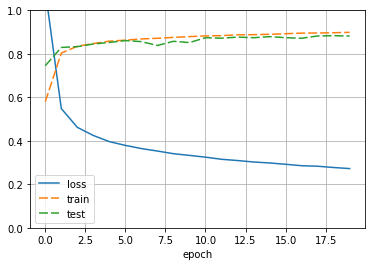

In [9]:
draw()